In [1]:
# The MIT License (MIT) Copyright (c) 2023 milmor
#
# Permission is hereby granted, free of charge, to any person obtaining a copy of
# this software and associated documentation files (the "Software"), to deal in the Software without
# restriction, including without limitation the rights to use, copy, modify, merge, publish,
# distribute, sublicense, and/or sell copies of the Software, and to permit persons to whom the
# Software is furnished to do so, subject to the following conditions:
#
# The above copyright notice and this permission notice shall be included in all copies or
# substantial portions of the Software.
#
# THE SOFTWARE IS PROVIDED "AS IS", WITHOUT WARRANTY OF ANY KIND, EXPRESS OR IMPLIED,
# INCLUDING BUT NOT LIMITED TO THE WARRANTIES OF MERCHANTABILITY, FITNESS FOR A PARTICULAR PURPOSE AND
# NONINFRINGEMENT. IN NO EVENT SHALL THE AUTHORS OR COPYRIGHT HOLDERS BE LIABLE FOR ANY CLAIM, DAMAGES
# OR OTHER LIABILITY, WHETHER IN AN ACTION OF CONTRACT, TORT OR OTHERWISE, ARISING FROM, OUT OF OR IN
# CONNECTION WITH THE SOFTWARE OR THE USE OR OTHER DEALINGS IN THE SOFTWARE.

# Conditional FastGAN
- En este notebook se define una arquitectura basada en [FastGAN](https://arxiv.org/abs/2101.04775), condicionada en las etiquetas de clase.

\begin{equation}
V(G, D) = \mathbb{E}_{x \sim p_{\text{r}}(x|y)}[\log D(x|y)] + \mathbb{E}_{z \sim p_{z}(z)}[\log (1 - D(G(z|y)))]
\label{eq:conditional_gan}
\end{equation}

- El código completo en Tensorflow se encuentra en [este repositorio](https://github.com/milmor/self-supervised-gan).

In [2]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3' # Disable tensorflow debugging logs
import tensorflow as tf
from tensorflow.keras import layers
import matplotlib.pyplot as plt
import numpy as np
import time

AUTOTUNE = tf.data.experimental.AUTOTUNE

- Descarga dataset.

In [3]:
(train_images, train_labels), (test_images, test_labels) = tf.keras.datasets.mnist.load_data()
train_images = train_images.reshape(train_images.shape[0], 28, 28, 1).astype('float32')
test_images = test_images.reshape(test_images.shape[0], 28, 28, 1).astype('float32')
train_images = (train_images - 127.5) / 127.5
test_images = (test_images - 127.5) / 127.5

In [4]:
train_images.shape

(60000, 28, 28, 1)

## 1.- Pipeline

In [5]:
def deprocess(img):
    return img * 127.5 + 127.5

In [6]:
def create_ds(images, labels, batch_size, seed=15):
    BUFFER_SIZE = images.shape[0]
    img_ds = tf.data.Dataset.from_tensor_slices((images, labels))
    ds = img_ds.cache().shuffle(
        BUFFER_SIZE, seed=seed).batch(
        batch_size, drop_remainder=True, num_parallel_calls=AUTOTUNE).prefetch(
        AUTOTUNE
    )
    print(f'Train dataset size: {BUFFER_SIZE}')
    print(f'Train batches: {tf.data.experimental.cardinality(ds)}')
    return ds

batch_size = 256
train_dataset = create_ds(train_images, train_labels, batch_size)

Train dataset size: 60000
Train batches: 234


In [7]:
train_batch, train_labels = next(iter(train_dataset))

In [8]:
train_batch.shape, train_labels.shape

(TensorShape([256, 28, 28, 1]), TensorShape([256]))

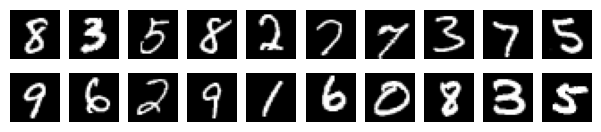

In [9]:
def plot_batch(batch):
    plt.figure(figsize=(7.5, 1.5))
    n_images = 20
    plot_batch = tf.cast(deprocess(batch), tf.uint8)
    for i in range(n_images):
        plt.subplot(2, 10, i+1)
        plt.imshow(plot_batch[i, :, :, :], cmap='gray')
        plt.axis('off')
    plt.show()

plot_batch(train_batch)

## 2.- Modelo
### Generador
- Define bloque para UpSampling.

In [10]:
def upBlock(filters, kernel_size=3, initializer='orthogonal'):
    block = tf.keras.Sequential([
            layers.UpSampling2D(2),
            layers.Conv2D(filters*2, kernel_size=kernel_size,
                padding='same', use_bias=False,
                kernel_initializer=initializer),
            layers.BatchNormalization(),
            layers.LeakyReLU(0.2)
    ])
    return block

In [11]:
class Generator(tf.keras.models.Model):
    def __init__(self, filters=128, dense_units=512, initializer='glorot_uniform'):
        super(Generator, self).__init__()
        self.init = tf.keras.Sequential([
            layers.Dense(7 * 7 * dense_units,
                         use_bias=False, kernel_initializer=initializer),
            layers.BatchNormalization(),
            layers.LeakyReLU(0.2),
            layers.Reshape((7, 7, dense_units))
        ])
        self.up_14 = upBlock(filters, initializer=initializer)
        self.up_28 = upBlock(filters // 2, initializer=initializer)

        self.ch_conv = layers.Conv2D(1, 3, padding='same',
                                     activation='tanh', kernel_initializer=initializer)

        self.emb = layers.Embedding(10, 128, name="embedding")

    def call(self, z, c):
        c = self.emb(c)
        #print(z.shape, c.shape)
        z = tf.concat([z, c], -1)

        feat_4 = self.init(z)
        feat_8 = self.up_14(feat_4)
        feat_16 = self.up_28(feat_8)
        img = self.ch_conv(feat_16)
        return img


noise_dim = 64
noise = tf.random.normal([batch_size, noise_dim])
generator = Generator(64, 64)
gen_batch = generator(noise, train_labels)
generator.summary()
gen_batch.shape

Model: "generator"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (256, 7, 7, 64)           614656    
                                                                 
 sequential_1 (Sequential)   (256, 14, 14, 128)        74240     
                                                                 
 sequential_2 (Sequential)   (256, 28, 28, 64)         73984     
                                                                 
 conv2d_2 (Conv2D)           multiple                  577       
                                                                 
 embedding (Embedding)       multiple                  1280      
                                                                 
Total params: 764,737
Trainable params: 758,081
Non-trainable params: 6,656
_________________________________________________________________


TensorShape([256, 28, 28, 1])

### Discriminador

- Define bloque residual.

In [12]:
def convBlock(filters, kernel_size=3, strides=1, padding='same',
              use_bias=False, kernel_initializer='orthogonal', use_bn=True):
    if use_bn:
        block = tf.keras.Sequential([
            layers.Conv2D(filters, kernel_size=kernel_size, strides=strides,
                padding='same', use_bias=use_bias, kernel_initializer=kernel_initializer),
            layers.BatchNormalization()
         ])
    else:
        block = layers.Conv2D(filters, kernel_size=kernel_size, strides=strides,
                padding='same', use_bias=use_bias, kernel_initializer=kernel_initializer)
    return block

In [13]:
class DownBlockComp(layers.Layer):
    def __init__(self, filters, initializer='orthogonal', use_bn=True):
        super(DownBlockComp, self).__init__()

        self.main = tf.keras.Sequential([
            convBlock(filters, kernel_size=4, padding='same',
                strides=2, use_bias=False, kernel_initializer=initializer, use_bn=use_bn),
            layers.LeakyReLU(0.2),
            convBlock(filters, kernel_size=3, padding='same',
                use_bias=False, kernel_initializer=initializer, use_bn=use_bn),
            layers.LeakyReLU(0.2),
        ])

        self.direct = tf.keras.Sequential([
            layers.AveragePooling2D((2, 2)),
            convBlock(filters, kernel_size=1, padding='same',
                use_bias=False, kernel_initializer=initializer, use_bn=use_bn),
            layers.LeakyReLU(0.2),
        ])

    def call(self, x):
        return (self.main(x) + self.direct(x)) / 2

In [14]:
class Discriminator(tf.keras.models.Model):
    def __init__(self, filters=128, initializer='orthogonal', use_bn=True):
        super(Discriminator, self).__init__()
        '''Encode image'''
        self.down_from_big = tf.keras.Sequential([
            layers.Conv2D(filters // 4, kernel_size=3, padding='same',
                use_bias=False, kernel_initializer=initializer),
            layers.LeakyReLU(0.2)
        ])
        self.down_16 = DownBlockComp(filters // 2, initializer=initializer, use_bn=use_bn)
        self.down_8 = DownBlockComp(filters, initializer=initializer, use_bn=use_bn)

        '''Logits'''
        self.logits = tf.keras.Sequential([
            layers.Conv2D(filters, kernel_size=1, padding='valid',
                use_bias=False, kernel_initializer=initializer),
            layers.LeakyReLU(0.2),
            layers.Conv2D(1, kernel_size=4, padding='valid',
                use_bias=False, kernel_initializer=initializer),
            layers.Flatten()
        ])

        self.emb = layers.Embedding(10, 128, name="embedding")

    def call(self, img, c):
        B = c.shape[0]
        c = self.emb(c)
        c = tf.reshape(c, [B, 1, 1, -1])
        c = tf.tile(c, [1, 14, 14, 1])
        feat_32 = self.down_from_big(img)
        feat_16 = self.down_16(feat_32)
        feat_16 = tf.concat([feat_16, c], -1)
     
        feat_8 = self.down_8(feat_16)
        logits = self.logits(feat_8)

        return logits


discriminator = Discriminator(128, use_bn=True)
out_disc = discriminator(train_batch, train_labels)
discriminator.summary()
out_disc.shape

Model: "discriminator"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_3 (Sequential)   (256, 28, 28, 32)         288       
                                                                 
 down_block_comp (DownBlockC  multiple                 72448     
 omp)                                                            
                                                                 
 down_block_comp_1 (DownBloc  multiple                 566784    
 kComp)                                                          
                                                                 
 sequential_14 (Sequential)  (256, 16)                 18432     
                                                                 
 embedding (Embedding)       multiple                  1280      
                                                                 
Total params: 659,232
Trainable params: 658,080
Non-t

TensorShape([256, 16])

## 3.- Entrenamiento
- Define funciones objetivo y optimizadores.

In [15]:
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

In [16]:
def discriminator_loss(real_output, fake_output):
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    total_loss = real_loss + fake_loss
    return total_loss

def generator_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output), fake_output)

In [17]:
g_lr = 0.0001
d_lr = 0.0001
beta_1 = 0.5
beta_2 = 0.9

g_opt = tf.keras.optimizers.Adam(learning_rate=g_lr,
                                 beta_1=beta_1,
                                 beta_2=beta_2)

d_opt = tf.keras.optimizers.Adam(learning_rate=d_lr,
                                 beta_1=beta_1,
                                 beta_2=beta_2)

- Define GAN.

In [18]:
class GAN(tf.keras.models.Model):
    def __init__(self, generator, discriminator, g_opt, d_opt, g_loss, d_loss):
        super(GAN, self).__init__()
        self.generator = generator
        self.g_opt = g_opt
        self.g_loss = g_loss
        self.discriminator = discriminator
        self.d_opt = d_opt
        self.d_loss = d_loss

        # Log metrics
        self.g_loss_avg = tf.keras.metrics.Mean()
        self.d_loss_avg = tf.keras.metrics.Mean()

    @tf.function
    def train_step(self, real_img, real_label):
        noise = tf.random.normal([batch_size, noise_dim])

        # Train the discriminator
        with tf.GradientTape() as disc_tape:
            gen_img = self.generator(noise, real_label, training=True)
            real_out = self.discriminator(real_img, real_label, training=True)
            fake_out = self.discriminator(gen_img, real_label, training=True)

            disc_loss = self.d_loss(real_out, fake_out)

        disc_gradients = disc_tape.gradient(disc_loss, self.discriminator.trainable_variables)
        self.d_opt.apply_gradients(zip(disc_gradients, self.discriminator.trainable_variables))

        noise = tf.random.normal([batch_size, noise_dim])

        # Train the generator
        with tf.GradientTape() as gen_tape:
            generator_output = self.generator(noise, real_label, training=True)
            fake_out = self.discriminator(generator_output, real_label, training=True)

            gen_loss = self.g_loss(fake_out)

        gen_gradients = gen_tape.gradient(gen_loss, self.generator.trainable_variables)
        self.g_opt.apply_gradients(zip(gen_gradients, self.generator.trainable_variables))

        self.g_loss_avg(gen_loss)
        self.d_loss_avg(disc_loss)

- Define modelo.

In [19]:
gan = GAN(generator, discriminator,
          g_opt, d_opt,
          generator_loss, discriminator_loss)

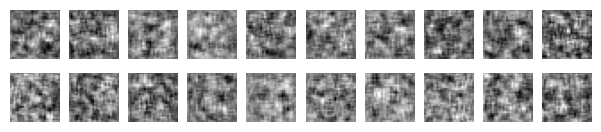

In [20]:
noise_seed = tf.random.normal([batch_size, noise_dim])
gen_batch = gan.generator(noise, train_labels)

plot_batch(gen_batch)

In [21]:
train_labels

<tf.Tensor: shape=(256,), dtype=uint8, numpy=
array([8, 3, 5, 8, 2, 7, 7, 3, 7, 5, 9, 6, 2, 9, 1, 6, 0, 8, 3, 5, 7, 1,
       4, 5, 6, 4, 1, 9, 5, 9, 9, 2, 3, 5, 8, 3, 1, 9, 9, 9, 5, 1, 1, 7,
       6, 6, 4, 7, 9, 6, 0, 3, 4, 1, 9, 4, 6, 9, 9, 8, 5, 8, 5, 9, 8, 8,
       0, 9, 9, 3, 1, 6, 0, 5, 6, 1, 9, 7, 5, 7, 1, 2, 9, 4, 8, 9, 3, 0,
       0, 1, 2, 5, 9, 8, 6, 0, 2, 8, 0, 8, 3, 0, 8, 5, 3, 5, 1, 8, 0, 3,
       9, 7, 2, 4, 8, 1, 7, 3, 9, 8, 2, 6, 0, 2, 2, 8, 1, 6, 7, 9, 9, 2,
       3, 4, 3, 5, 3, 3, 5, 6, 0, 6, 0, 1, 3, 2, 0, 4, 1, 0, 8, 5, 4, 1,
       2, 2, 5, 3, 9, 7, 6, 0, 4, 9, 6, 4, 3, 6, 0, 6, 4, 6, 2, 2, 4, 8,
       7, 0, 0, 2, 1, 1, 2, 5, 7, 1, 1, 1, 7, 6, 7, 5, 4, 0, 7, 1, 1, 4,
       3, 1, 9, 2, 6, 1, 4, 2, 7, 8, 9, 5, 1, 0, 8, 3, 3, 2, 7, 3, 5, 8,
       8, 8, 5, 4, 5, 4, 7, 1, 3, 2, 1, 9, 0, 2, 2, 2, 4, 0, 7, 0, 8, 2,
       1, 6, 7, 8, 1, 3, 7, 7, 2, 3, 4, 2, 0, 3], dtype=uint8)>

In [22]:
epochs = 24
plot_inter = 3

def train(model, epochs, dataset, plot_inter):
    for epoch in range(epochs):
        start = time.time()
        for image_batch, labels_batch in dataset:
            model.train_step(image_batch, labels_batch)

        g_loss = model.g_loss_avg.result()
        d_loss = model.d_loss_avg.result()
        print(f'Time for epoch {epoch} is {time.time()-start:.4f} sec', end=' ')
        print(F'G loss: {g_loss:.4f} D loss: {d_loss:.4f}')
        if epoch % plot_inter == 0:
            gen_batch = model.generator(noise_seed, train_labels, training=False)
            plot_batch(gen_batch)

        model.g_loss_avg.reset_states()
        model.d_loss_avg.reset_states()

Time for epoch 0 is 12.7269 sec G loss: 1.6636 D loss: 0.6732


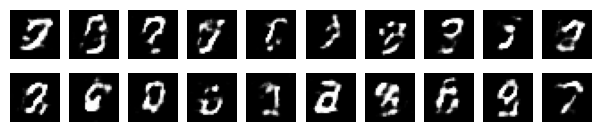

Time for epoch 1 is 7.1465 sec G loss: 2.5921 D loss: 0.3925
Time for epoch 2 is 6.9384 sec G loss: 3.3549 D loss: 0.2627
Time for epoch 3 is 7.2195 sec G loss: 3.4608 D loss: 0.2759


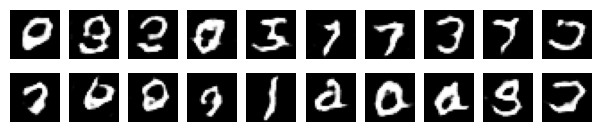

Time for epoch 4 is 6.9893 sec G loss: 3.3061 D loss: 0.3112
Time for epoch 5 is 7.3204 sec G loss: 3.1042 D loss: 0.3676
Time for epoch 6 is 7.1235 sec G loss: 2.8325 D loss: 0.4474


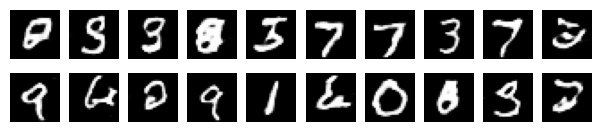

Time for epoch 7 is 7.1422 sec G loss: 2.6801 D loss: 0.4871
Time for epoch 8 is 7.2245 sec G loss: 2.5827 D loss: 0.5071
Time for epoch 9 is 7.4263 sec G loss: 2.4285 D loss: 0.5636


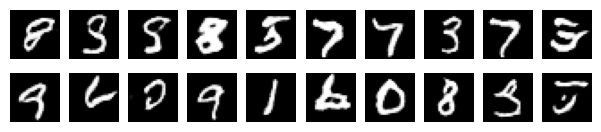

Time for epoch 10 is 7.2684 sec G loss: 2.2422 D loss: 0.6374
Time for epoch 11 is 7.2436 sec G loss: 2.0542 D loss: 0.7049
Time for epoch 12 is 7.3483 sec G loss: 1.9432 D loss: 0.7654


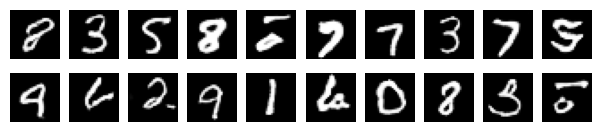

Time for epoch 13 is 7.3479 sec G loss: 1.8233 D loss: 0.8003
Time for epoch 14 is 7.3275 sec G loss: 1.6791 D loss: 0.8416
Time for epoch 15 is 7.1676 sec G loss: 1.5964 D loss: 0.8892


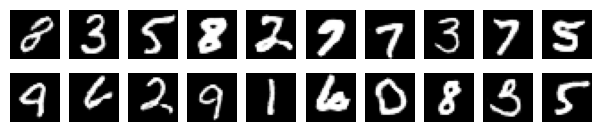

Time for epoch 16 is 7.1670 sec G loss: 1.5250 D loss: 0.9165
Time for epoch 17 is 7.1594 sec G loss: 1.5067 D loss: 0.9297
Time for epoch 18 is 7.0970 sec G loss: 1.4997 D loss: 0.9332


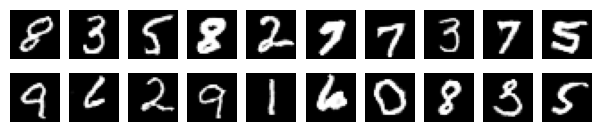

Time for epoch 19 is 7.2042 sec G loss: 1.5113 D loss: 0.9058
Time for epoch 20 is 7.1441 sec G loss: 1.5150 D loss: 0.9056
Time for epoch 21 is 7.0742 sec G loss: 1.5712 D loss: 0.8788


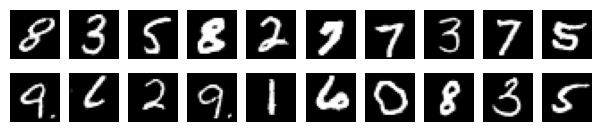

Time for epoch 22 is 7.0966 sec G loss: 1.6221 D loss: 0.8538
Time for epoch 23 is 7.0588 sec G loss: 1.6411 D loss: 0.8517


In [23]:
train(gan, epochs, train_dataset, plot_inter)